# SEQ Task

In [1]:
from glob import glob
from scipy import stats
from math import sqrt
import nibabel as nb
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_palette('muted')

#20 subjects
sids = ['783126', '783127', '783130', '783131', '783132', '783133', '783135', '783136', '783137', '783138', 
        '783139', '783144', '783146', '783148', '783149', '783150', '783152', '783153', '783155', '783158'] 

proj_dir = '/home/data/madlab/data/mri/seqtrd' 
mask_filenames = []
cope_files = []
for SID in sids:
    subjmasks = glob(proj_dir + '/mask/cortical_rois/{0}/anat_masks/_subject_id_{0}/*'.format(SID))
    mask_filenames.append(sorted(subjmasks))
    subjcopes = glob(proj_dir + '/scndlvl/seq_1stpos_cic_FINAL/' 
                     + SID + '/seq_1stpos_cic_bl/fixedfx/cope*.nii.gz')
    cope_files.append(sorted(subjcopes))   
    if len(cope_files[-1]) == 0 or len(cope_files[-1]) != 32:
        print(SID)

/home/data/madlab/envs/seqtrd_madlab_env/lib/python2.7/site-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)
/home/data/madlab/envs/seqtrd_madlab_env/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Cell to double-check the array indexing

In [2]:
test_sub = 0
for i, curr_mask in enumerate(mask_filenames[test_sub]):
    print(i, mask_filenames[test_sub][i].split('/')[-1][:-7])

(0, 'cerebellum_bimask_warped')
(1, 'l_ant_hpc_warped')
(2, 'l_cerebellum_bimask_warped')
(3, 'lh-angular-gyrus_fs_warped')
(4, 'lh-caudate_warped')
(5, 'lh-motor_fs_warped')
(6, 'lh-pcc_fs_warped')
(7, 'lh-precuneus_fs_warped')
(8, 'lh-superiortemporalctx_warped')
(9, 'lh_hpc_warped')
(10, 'lh_mpfc_warped')
(11, 'limbicthal_bin_trans_warped')
(12, 'r_ant_hpc_warped')
(13, 'r_cerebellum_bimask_warped')
(14, 'rh-angular-gyrus_fs_warped')
(15, 'rh-caudate_warped')
(16, 'rh-motor_fs_warped')
(17, 'rh-pcc_fs_warped')
(18, 'rh-precuneus_fs_warped')
(19, 'rh-superiortemporalctx_warped')
(20, 'rh_hpc_warped')
(21, 'rh_mpfc_warped')
(22, 'seq_bold_r01_dtype_despike_roi')
(23, 'x_bihemi_mpfc_warped')
(24, 'x_combined_antHC_mPFC_mask')


In [3]:
for i, curr_cope in enumerate(cope_files[1]):
    print(i, cope_files[1][i].split('/')[-1][5:-7]) 

(0, 'InseqCorr_minus_InseqIncorr')
(1, 'InseqCorr_minus_OTCorr')
(2, 'InseqCorr_minus_OTIncorr')
(3, 'InseqCorr_minus_OutseqCorr')
(4, 'InseqCorr_minus_RepeatCorr')
(5, 'InseqCorr_minus_RepeatIncorr')
(6, 'InseqCorr_minus_SkipCorr')
(7, 'InseqCorr_minus_SkipIncorr')
(8, 'InseqIncorr_minus_InseqCorr')
(9, 'InseqIncorr_minus_OutseqIncorr')
(10, 'OTCorr_minu_InseqCorr')
(11, 'OTCorr_minus_OTIncorr')
(12, 'OTIncorr_minus_InseqCorr')
(13, 'OTIncorr_minus_OTCorr')
(14, 'OutseqCorr_minus_InseqCorr')
(15, 'OutseqIncorr_minus_InseqIncorr')
(16, 'RepeatCorr_minu_InseqCorr')
(17, 'RepeatCorr_minus_RepeatIncorr')
(18, 'RepeatIncorr_minus_InseqCorr')
(19, 'RepeatIncorr_minus_RepeatCorr')
(20, 'SkipCorr_minu_InseqCorr')
(21, 'SkipCorr_minus_SkipIncorr')
(22, 'SkipIncorr_minus_InseqCorr')
(23, 'inseq_corr')
(24, 'inseq_incorr')
(25, 'ot_corr')
(26, 'ot_incorr')
(27, 'repeat_corr')
(28, 'repeat_incorr')
(29, 'skipIncorr_minus_SkipCorr')
(30, 'skip_corr')
(31, 'skip_incorr')


### Use binarized mask to obtain activation in left & right hemisphere for each region of interest

In [4]:
trials = {"mpfc_inseq_corr":[], "mpfc_inseq_incorr":[], "mpfc_ot_corr":[], "mpfc_ot_incorr":[],
          "motor_inseq_corr":[], "motor_inseq_incorr":[], "motor_ot_corr":[], "motor_ot_incorr":[],}
                     
for i in range(len(sids)):
    lh_mpfc_img = nb.load(mask_filenames[i][10])
    rh_mpfc_img = nb.load(mask_filenames[i][21])
    lh_motor_img = nb.load(mask_filenames[i][5])
    rh_motor_img = nb.load(mask_filenames[i][16])
    
    inseq_corr_img = nb.load(cope_files[i][23])
    inseq_incorr_img = nb.load(cope_files[i][24])
    ot_corr_img = nb.load(cope_files[i][25])
    ot_incorr_img = nb.load(cope_files[i][26])
 
    for d in ['inseq_corr', 'inseq_incorr', 'ot_corr', 'ot_incorr']:
        for r in ['mpfc', 'motor']:
            lh_data = eval('{0}_img.get_data()[lh_{1}_img.get_data() > 0.]'.format(d,r))   
            rh_data = eval('{0}_img.get_data()[rh_{1}_img.get_data() > 0.]'.format(d,r))
            bihemi_data = np.concatenate((lh_data, rh_data)) 
            eval('trials["{0}_{1}"].append(np.median(bihemi_data))'.format(r,d))
                                
trials_df = pd.DataFrame(trials) 

In [5]:
trials_df

,motor_inseq_corr,motor_inseq_incorr,motor_ot_corr,motor_ot_incorr,mpfc_inseq_corr,mpfc_inseq_incorr,mpfc_ot_corr,mpfc_ot_incorr
0,-0.719957,0.693966,-1.832809,-0.922673,-1.412573,-0.210639,-1.943442,0.758997
1,-0.347114,-0.648868,-3.061363,-2.944011,-1.692472,-1.706756,-3.113516,-2.180955
2,-0.049482,3.949605,-0.651781,0.357467,-1.581157,2.161545,-3.583645,-1.602572
3,0.514783,2.703427,0.001709,2.373159,-1.153356,0.247073,-6.389302,-1.240625
4,1.416024,-3.926096,-0.087069,2.141309,0.332584,-1.406004,1.004104,1.807377
5,6.958126,10.400863,0.706910,3.182312,0.339409,4.370116,-3.698504,-0.843582
6,0.262187,-2.271109,-3.389269,-0.606035,-0.489632,-1.535239,-0.687001,-0.261949
7,-4.265722,-5.082541,-10.880045,-7.723786,-2.356155,-2.981571,-4.822291,-1.914350
8,4.244906,3.359319,6.116408,4.710445,2.484197,2.297935,3.001225,3.063044
9,-0.014548,-1.856685,-2.408848,-2.820633,-2.480793,-4.287919,-3.015271,-2.550682


# OT Probes

Mean motor_ot_corr:  -0.5816083960176911
STD motor_ot_corr:  3.654513200023907
Shapiro's Test of Normality: (0.91865473985672, 0.09335239976644516)
--------
Mean motor_ot_incorr:  0.3572409048676491
STD motor_ot_incorr:  3.461409499644748
Shapiro's Test of Normality: (0.9386314153671265, 0.22588661313056946)
--------
Mean mpfc_ot_corr:  -1.2700326098129153
STD mpfc_ot_corr:  2.506635078371053
Shapiro's Test of Normality: (0.9770694375038147, 0.8909287452697754)
--------
Mean mpfc_ot_incorr:  -0.5500193268060685
STD mpfc_ot_incorr:  2.1847888713726267
Shapiro's Test of Normality: (0.9624772071838379, 0.5944386720657349)
--------
Corr vs. Incorr
mPFC:  Ttest_relResult(statistic=-1.645283211488722, pvalue=0.11635422389384918)
Motor:  Ttest_relResult(statistic=-2.693162284681907, pvalue=0.01440005860702566)


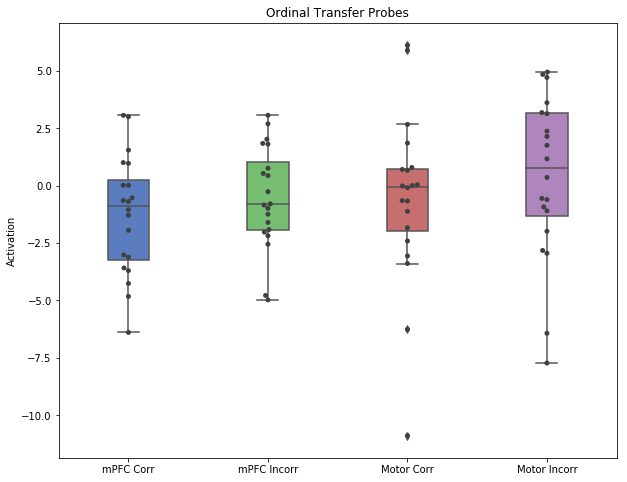

In [8]:
for key in trials_df:
    if "_ot_" in key:
        print "Mean {0}: ".format(key), np.mean(trials_df['{0}'.format(key)])
        print "STD {0}: ".format(key), np.std(trials_df['{0}'.format(key)])
        print "Shapiro's Test of Normality:", stats.shapiro(trials_df['{0}'.format(key)])
        print "--------"
print "Corr vs. Incorr"
print "mPFC: ", stats.ttest_rel(trials_df['mpfc_ot_corr'], trials_df['mpfc_ot_incorr'])
print "Motor: ", stats.ttest_rel(trials_df['motor_ot_corr'], trials_df['motor_ot_incorr'])
N = 4
conditions = ['mPFC Corr','mPFC Incorr', 'Motor Corr', 'Motor Incorr']
mpfc_allsubjs = [trials_df['mpfc_ot_corr'], trials_df['mpfc_ot_incorr'], 
                 trials_df['motor_ot_corr'], trials_df['motor_ot_incorr']]
ind = np.arange(N)
fig, ax = plt.subplots(figsize = (10,8))
ax0 = sns.boxplot(data = mpfc_allsubjs, width = 0.3)
ax2 = sns.swarmplot(data = mpfc_allsubjs, color='.25')
ax.set_xticks(ind)
ax.set_xticklabels(conditions)
ax.set_title("Ordinal Transfer Probes")
ax.set_ylabel("Activation")
plt.show()

# Inseq Trials

Mean motor_inseq_corr:  0.799256271449849
STD motor_inseq_corr:  2.618958563651739
Shapiro's Test of Normality: (0.9524838328361511, 0.40637338161468506)
--------
Mean motor_inseq_incorr:  0.4922387860715389
STD motor_inseq_incorr:  3.9052472286253748
Shapiro's Test of Normality: (0.9720413088798523, 0.7972753643989563)
--------
Mean mpfc_inseq_corr:  -0.8574732807930558
STD mpfc_inseq_corr:  1.8271540297762714
Shapiro's Test of Normality: (0.9780995845794678, 0.907267689704895)
--------
Mean mpfc_inseq_incorr:  -0.4845208339393139
STD mpfc_inseq_incorr:  2.592996022370537
Shapiro's Test of Normality: (0.9709469079971313, 0.7747392654418945)
--------
Corr vs Incorr
mPFC:  Ttest_relResult(statistic=-0.9632377314751619, pvalue=0.34752843151324186)
Motor:  Ttest_relResult(statistic=0.6131572703928643, pvalue=0.5470428293205098)


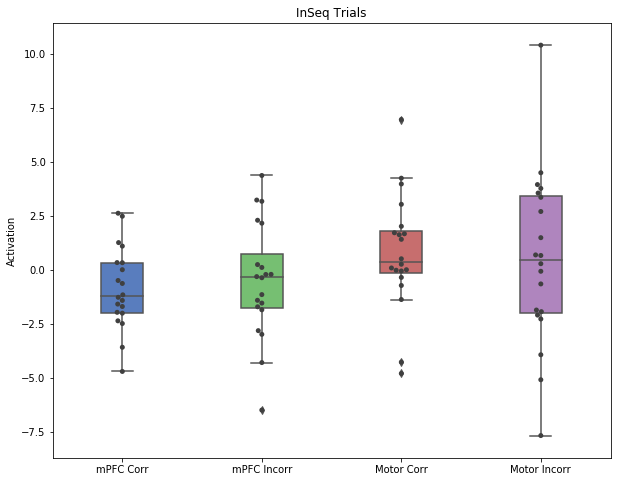

In [9]:
for key in trials_df:
    if "_inseq_" in key:
        print "Mean {0}: ".format(key), np.mean(trials_df['{0}'.format(key)])
        print "STD {0}: ".format(key), np.std(trials_df['{0}'.format(key)])
        print "Shapiro's Test of Normality:", stats.shapiro(trials_df['{0}'.format(key)])
        print "--------"
print "Corr vs Incorr"
print "mPFC: ", stats.ttest_rel(trials_df['mpfc_inseq_corr'], trials_df['mpfc_inseq_incorr'])
print "Motor: ", stats.ttest_rel(trials_df['motor_inseq_corr'], trials_df['motor_inseq_incorr'])
N = 4
conditions = ['mPFC Corr', 'mPFC Incorr', 'Motor Corr', 'Motor Incorr']
mpfc_allsubjs = [trials_df['mpfc_inseq_corr'], trials_df['mpfc_inseq_incorr'], 
                 trials_df['motor_inseq_corr'], trials_df['motor_inseq_incorr']]
ind = np.arange(N)
fig, ax = plt.subplots(figsize = (10,8))
ax0 = sns.boxplot(data = mpfc_allsubjs, width = 0.3)
ax2 = sns.swarmplot(data = mpfc_allsubjs, color='.25')
ax.set_xticks(ind)
ax.set_xticklabels(conditions)
ax.set_title("InSeq Trials")
ax.set_ylabel("Activation")
plt.show()